In [1]:
%pylab inline

import pandas as pd
import healpy as hp
import math

from scipy import interpolate, stats, special, arange, array, optimize
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord


Populating the interactive namespace from numpy and matplotlib


## Functions for likelihood

In [2]:
#HAWC Bkg Term
def probBkgHAWC(dec):
    zenith = 50.
    A = 0.5 * (special.erf(zenith/(np.sqrt(2)*23.55)) - special.erf(-zenith/(np.sqrt(2)*23.55)))
    #The 2 pi is from the uniform distribution in RA
    return A*exp(-(dec-18.98)**2/(2*23.55**2))/(np.sqrt(2*np.pi*np.deg2rad(23.55)**2) * 2*np.pi) 

##IC Bkg Term
def probBkgIC(sinDec):
    x=sinDec
    #numbers obtained from archival data after doing a fit
    a=1.035595
    x0=-0.117645
    g1 = 0.81984
    g2 = 1.655227
    y = a*(1/np.pi) * ((g1/2)/((x-x0)**2 + (g1**2/4))) * ((x-x0)<0)
    y+= (a*g2/g1)*((1/np.pi) * ((g2/2)/((x-x0)**2 + (g2**2/4))) ) * ((x-x0)>=0)
    return y/(2*np.pi)

# angular separation between two events
def spcang (ra1, ra2, dec1, dec2):
    ra1 = np.deg2rad(ra1)
    ra2 = np.deg2rad(ra2)
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    return np.rad2deg(np.arccos(np.cos(dec1)*np.cos(dec2)*np.cos((ra1-ra2))+np.sin(dec1)*np.sin(dec2)))

# Define an initial space log-likelihood for each event (dec and ra are coordinates of the source position)
# Assumes a gaussian PDF
def loglh(dec1,ra1,dec,ra,sigma1,bkgterm):
    spc=np.deg2rad(spcang(ra1,ra,dec1,dec))
    #s = np.deg2rad(sigma1)**2+np.deg2rad(sigma)**2
    return -spc**2/(2*(np.deg2rad(sigma1))**2) - 0.5*np.log(2*np.pi*(np.deg2rad(sigma1))**2)-np.log(bkgterm)

# Find total log-likelihood considering multiplets: only spatial terms
def tloglh(dec,ra,events):
    val = 0
    for nut in events:
        dec1 = nut[0]
        ra1 = nut[1]
        sigma1 = nut[2]
        bkg=nut[4]
        # adding log-likelihood spatial terms
        val = val + loglh(dec1,ra1,dec,ra,sigma1,bkg)
    return val

#T1=[]
#T2=[]

def tloglh_time(dec,ra,events):
    val = 0
    for nut in events:
        dec1 = nut[0]
        ra1 = nut[1]
        sigma1 = nut[2]
        bkg=nut[4]
        # adding log-likelihood spatial terms
        val = val + loglh(dec1,ra1,dec,ra,sigma1,bkg)
        
    if len(events) > 2:
        T=0.
        #t1 =0.
        #t2=0.
        #print len(events)
        for i in range(1,len(events)-1) :
            for j in range(i+1,len(events)) :
                # adding temporal term (T is a normlization factor that can be modified to match spatial terms)
                #val = val - abs(((events[i][3]-events[j][3])).seconds)/T
                #print ((events[j][3]-events[i][3])).seconds
                #t1 += - abs(((events[j][3]-events[i][3])).seconds)/(events[0][3]*3600.) - np.log(events[0][3]*3600.)
                #t2 += np.log(events[0][3]*3600.) - np.log(abs(((events[j][3]-events[i][3])).seconds))
                T += np.log(events[0][3]*3600.) - np.log(abs(((events[j][3]-events[i][3])).seconds))
        #T1.append(t1)
        #T2.append(t2)
        val+=T       
    return val

def pNuCluster(events):
    val=1
    N=len(events)-1
    if N==1:
        return val
    else:
        lmb = 0.0066887 * events[0][3]*3600.*2*np.pi*(1-np.cos(np.deg2rad(3.5)))/(4*np.pi) #Rate=0.0066887 = 22334./ 3339043.sec
        for i in range(0,N-1) :
            val = val - np.exp(-lmb)*(lmb)**i/np.math.factorial(i)
    return val

cdf_saf=[]
data_saf = np.load('CDF_SAF.npz')
for item in data_saf.iteritems():
    cdf_saf.append(item[1])
n_saf = cdf_saf[0]
b_saf = cdf_saf[1]
b_saf_centers = b_saf[:-1] + 0.5*(b_saf[1:] - b_saf[:-1])
f_saf = interp1d(b_saf_centers,n_saf)
def pHEN(SAF):
    x=np.log10(SAF)
    if x < b_saf_centers[0]:
        y=1.
        print "Neutrino: WARNING x below range"
    elif x> b_saf_centers[-1]:
        y=1.-f_saf(b_saf_centers[-2])
        print "Neutrino: WARNING x above range"
    else:
        y=1.-f_saf(x)
    if y<0:
        print y
    return y

def totalpHEN(events):
    val=1
    N=len(events)
    if N==2:
        return val
    else:
        for i in range(1,N):
            val*=ev[i][-1]
        return val

## Prepare data for more than one simulation

In [18]:
%%time
#Using several simulations
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
#best_fit_val_time = []
best_fit_val = []

#Combine the HAWC month of data with 1200 scrambled months of IC data. -> Simulating 1200 months of data. 
for i in xrange(1):
    #HAWC sim
    #dfh = pd.read_csv("HAWC_simulations/2016-01-01_{}-times.txt".format(i+1),delimiter=" ")
    dfh = pd.read_csv("HAWC_scrambled/{}.csv".format(i))
    #dfh.head(2)
    dfh['HTime_c']=pd.to_datetime(dfh['HTime_c'])
    dfh = dfh.sort_values(by='HTime_c')
    dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
    dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
    sigma_hawc = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=len(dfh), random_state=None)#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    dfh['HsigmaR']=sigma_hawc
    #print dfh.head(0)
    #IC sim
    dfic = pd.read_csv("IC_scrambled2/{}.csv".format(i))
    #print dfic.head(0)
    dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
    dfic = dfic.sort_values(by='ICtime')
    #dfic['ICFPRD'] = np.power(10,-2.5)#np.power(10,signaless(len(dfic)))



    all_event_list=[]
    for h in dfh.itertuples():
        dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
        event_list=[]
        event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,probBkgHAWC(h.HDec),1-stats.norm.cdf(h.Hsig)])
        for ic in dfw.itertuples():
            spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
            if spc<minspc:
                #event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), np.deg2rad(np.deg2rad(ic.ICFPRD))*h.Hduration,1.])
                event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), probBkgIC(np.sin(np.deg2rad(ic.ICDec))),pHEN(ic.ICsigs/ic.ICFPRD)])
        all_event_list.append(event_list)
    
    #Just paired events
    all_ev_nut = [x for x in all_event_list if len(x)>1]
    
    #print len(all_ev_nut)
    
    for ev in all_ev_nut:
        #if TempTerm:
        solution = optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
        #else:
        #solution = optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')#'BFGS')
        pcluster = pNuCluster(ev)
        phwcsigma = ev[0][5]
        picsigma = totalpHEN(ev)
    
    
        stderr = 0.
        jacerr = 0.
        avgdist = 0.
        stddev = 0.
        j=0
        n=0

        if solution.success:
            res = list(solution.x)
            for part in ev:
                #print part[0],part[1],part[2],solution.x[0],solution.x[1]
                stderr += 1./(part[2]**2)
                tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
                tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
                stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
                avgdist +=tmpdist1#+ tmpdist2
                #print tmpdist1, tmpdist2
                j+=1
            #print avgdist,solution.fun
            stderr = np.sqrt(1/stderr)
            jacerr = np.sqrt(jacerr)
            avgdist /= j
            stddev /= j
            stddev = np.sqrt(stddev)
    
            res.append(stderr)
            #res.append(jacerr)
            res.append(-1*solution.fun)
            res.append(avgdist)
            res.append(stddev)
            res.append(len(ev)-1)
            res.append(pcluster)
            res.append(phwcsigma)
            res.append(picsigma)
            res.append(ev)
            best_fit_val.append(res)

Neutrino: WARNING x above range
Neutrino: WARNING x above range
Neutrino: WARNING x above range
Neutrino: WARNING x above range
Neutrino: WARNING x above range
Neutrino: WARNING x above range
Neutrino: WARNING x above range
Neutrino: WARNING x above range
CPU times: user 20min 15s, sys: 8.92 s, total: 20min 23s
Wall time: 20min 46s


In [19]:
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[-1]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[-1]) > 2])
icPV = np.asarray([x[9] for x in best_fit_val])
hawcPV = np.asarray([x[8] for x in best_fit_val])
pCluster = np.asarray([x[7] for x in best_fit_val])

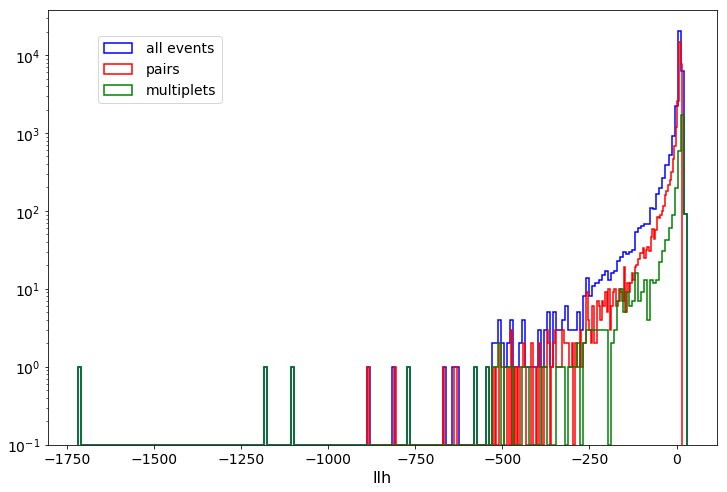

In [20]:
# Plot the histogram of llh values
rcParams['figure.figsize']=12,8
_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         #range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         #range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         #range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.26,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'$\lambda$',fontsize=16)

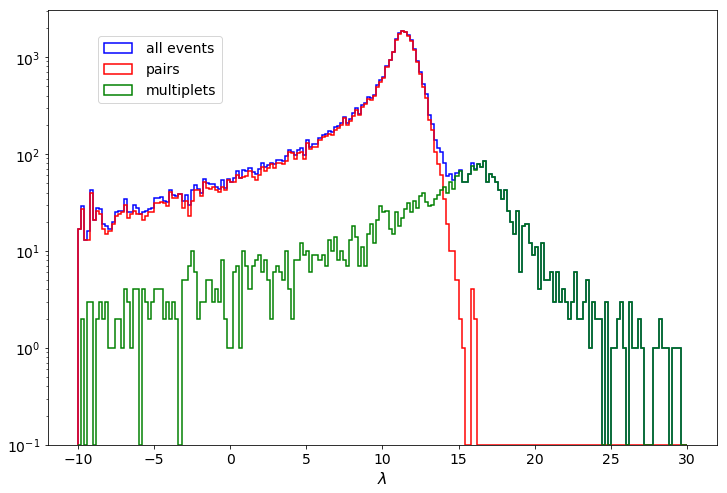

In [21]:
# Plot the histogram of llh values
rcParams['figure.figsize']=12,8
therange=[-10,30]
_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=therange,
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=therange,
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=therange,
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.26,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'$\lambda$',fontsize=16)
#savefig("plots/llh_1year_v2.png")

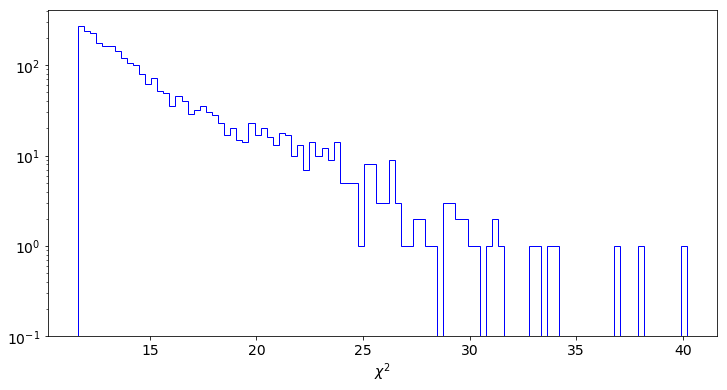

In [7]:
rcParams['figure.figsize']=12,6
rcParams['font.size']=14
cdfLLH =  np.load('CDF_LLH.npz')
cdf_LLH = []
for item in cdfLLH.iteritems():
    cdf_LLH.append(item[1])
n_llh = cdf_LLH[0]
b_llh = cdf_LLH[1]
b_llh_centers = b_llh[:-1] + 0.5*(b_llh[1:] - b_llh[:-1])

f = interp1d(b_llh_centers, n_llh)
chi2 = -2 * np.log(icPV*hawcPV*pCluster*(1-f(likelihood)))
n,b,o=hist(chi2,bins=100,histtype='step',log=True,color='b',label='All')
xlabel(r'$\chi^2$')
#grid(ls='--',which='both')
#savefig("plots/chi2_1year_v2.png")

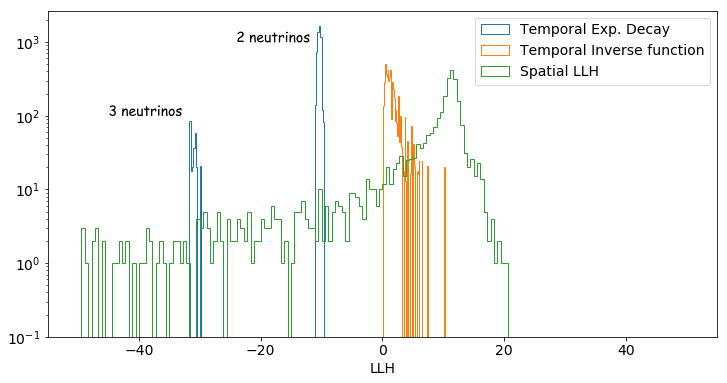

In [166]:
#hist(T1,bins=100,histtype='step',log=True,label="Temporal Exp. Decay")
#hist(T2,bins=80,histtype='step',log=True,label="Temporal Inverse function")
#hist(likelihood,bins=180,histtype='step',range=(-50,50),log=True,label="Spatial LLH")
#legend()
#xlabel("LLH")

#with plt.xkcd():
    #text(-45,1e2,"3 neutrinos")
    #text(-24,1e3,"2 neutrinos")

## Simulation of fake coincidences

In [44]:
events = []
events.append([14.0,245.,0.1,6.9,probBkgHAWC(14.0),1-stats.norm.cdf(3)])
events.append([14.1,244.9,0.25,pd.Timestamp('2016-01-27 12:26:24'),probBkgIC(np.sin(np.deg2rad(14.1))),pHEN(0.9298/2.5e-5)])
events.append([13.9,245.1,0.2,pd.Timestamp('2016-01-27 12:27:24'),probBkgIC(np.sin(np.deg2rad(13.9))),pHEN(0.9614/0.00022)])


all_events = []
all_events.append(events)
print all_events
print
best_fit_val = []
for ev in all_events:
    solution = optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
    #else:
    #solution = optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')#'BFGS')
    pcluster = pNuCluster(ev)
    phwcsigma = ev[0][5]
    picsigma = totalpHEN(ev)
    
    
    stderr = 0.
    jacerr = 0.
    avgdist = 0.
    stddev = 0.
    j=0
    n=0

    if solution.success:
        res = list(solution.x)
        for part in ev:
            #print part[0],part[1],part[2],solution.x[0],solution.x[1]
            stderr += 1./(part[2]**2)
            tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
            tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
            stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
            avgdist +=tmpdist1#+ tmpdist2
            #print tmpdist1, tmpdist2
            j+=1
        #print avgdist,solution.fun
        stderr = np.sqrt(1/stderr)
        jacerr = np.sqrt(jacerr)
        avgdist /= j
        stddev /= j
        stddev = np.sqrt(stddev)
    
        res.append(stderr)
        #res.append(jacerr)
        res.append(-1*solution.fun)
        res.append(avgdist)
        res.append(stddev)
        res.append(len(ev)-1)
        res.append(pcluster)
        res.append(phwcsigma)
        res.append(picsigma)
        res.append(ev)
        best_fit_val.append(res)

likelihood = np.asarray([x[3] for x in best_fit_val])
icPV = np.asarray([x[9] for x in best_fit_val])
hawcPV = np.asarray([x[8] for x in best_fit_val])
pCluster = np.asarray([x[7] for x in best_fit_val])

print likelihood

cdfLLH =  np.load('CDF_LLH.npz')
cdf_LLH = []
for item in cdfLLH.iteritems():
    cdf_LLH.append(item[1])
n_llh = cdf_LLH[0]
b_llh = cdf_LLH[1]
b_llh_centers = b_llh[:-1] + 0.5*(b_llh[1:] - b_llh[:-1])

f = interp1d(b_llh_centers, n_llh)
psky = 1-f(likelihood)
print psky,icPV,hawcPV,pCluster

print -2.*np.log(icPV*hawcPV*pCluster*psky)

Neutrino: WARNING x above range
[[[14.0, 245.0, 0.1, 6.9, 0.14596367315538997, 0.0013498980316301035], [14.1, 244.9, 0.25, Timestamp('2016-01-27 12:26:24'), 0.10750219849345663, 0.00044774782842249561], [13.9, 245.1, 0.2, Timestamp('2016-01-27 12:27:24'), 0.10782425947650176, 0.059742605815434446]]]

[ 26.70150428]
[ 0.00029837] [  2.67496220e-05] [ 0.0013499] [ 0.14354124]
[ 54.39007813]


13430
0.954206999255 0.000744601638124
13523
0.957627745323 0.00118316941507
13186
0.956999848324 0.00182011224025
13217
0.954074298252 0.00113490202013
13388
0.958843740663 0.00126979384523


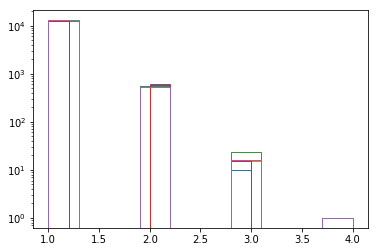

In [136]:
lmb = 0.0066887 * 4.*3600.*2*np.pi*(1-np.cos(np.deg2rad(3.5)))/(4*np.pi)
for i in xrange(5):
    s = np.random.poisson(lmb,155000)
    s=s[s>0]
    print len(s)
    total  = float(len(s))
    ones = float(len(s[s<2]))
    moretwos = float(len(s[s>2]))
    print ones/total, moretwos/total
    hist(s,histtype="step")
    yscale('log')

In [230]:
#Function to get HAWC duration
x2=np.linspace(-25,65,9000)
times50 = np.genfromtxt("ExpMaps/transit_55.txt")
f50 = interp1d(x2, times50)

all_events = []
for i in xrange(1000):
    events = []

    phDec = 14.0
    phRA = 156.0
    phErr = 0.1
    phDuration = f50(phDec)
    phBkg = probBkgHAWC(phDec)
    phSigma=4.0
    phPvalue = 1-stats.norm.cdf(phSigma)

    events.append([phDec,phRA,phErr,phDuration,phBkg,phPvalue])
    numNu = 2
    for j in xrange(numNu):
        nuDec = np.random.normal(phDec,phErr)
        nuRA = np.random.normal(phRA,phErr)
        nuErr = 0.3
        nuTime = pd.Timestamp('2016-01-27 12:27:24')
        if j>0:
            nuTime+=pd.Timedelta(seconds=np.random.uniform(high=phDuration*3600))
        nuBkg = probBkgIC(np.sin(np.deg2rad(nuDec)))
        nuPvalue = pHEN(np.power(10,np.random.uniform(3,3.8)))
        events.append([nuDec,nuRA,nuErr,nuTime,nuBkg,nuPvalue])
    
        #print nuDec,nuRA,nuTime
    
    all_events.append(events)

In [231]:

best_fit_val = []
for ev in all_events:
    solution = optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
    #else:
    #solution = optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')#'BFGS')
    pcluster = pNuCluster(ev)
    phwcsigma = ev[0][5]
    picsigma = totalpHEN(ev)
    
    
    stderr = 0.
    jacerr = 0.
    avgdist = 0.
    stddev = 0.
    j=0
    n=0

    if solution.success:
        res = list(solution.x)
        for part in ev:
            #print part[0],part[1],part[2],solution.x[0],solution.x[1]
            stderr += 1./(part[2]**2)
            tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
            tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
            stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
            avgdist +=tmpdist1#+ tmpdist2
            #print tmpdist1, tmpdist2
            j+=1
        #print avgdist,solution.fun
        stderr = np.sqrt(1/stderr)
        jacerr = np.sqrt(jacerr)
        avgdist /= j
        stddev /= j
        stddev = np.sqrt(stddev)
    
        res.append(stderr)
        #res.append(jacerr)
        res.append(-1*solution.fun)
        res.append(avgdist)
        res.append(stddev)
        res.append(len(ev)-1)
        res.append(pcluster)
        res.append(phwcsigma)
        res.append(picsigma)
        res.append(ev)
        best_fit_val.append(res)

likelihood = np.asarray([x[3] for x in best_fit_val])
icPV = np.asarray([x[9] for x in best_fit_val])
hawcPV = np.asarray([x[8] for x in best_fit_val])
pCluster = np.asarray([x[7] for x in best_fit_val])

print "LLH: ", likelihood, "p-value: ",psky

cdfLLH =  np.load('CDF_LLH.npz')
cdf_LLH = []
for item in cdfLLH.iteritems():
    cdf_LLH.append(item[1])
n_llh = cdf_LLH[0]
b_llh = cdf_LLH[1]
b_llh_centers = b_llh[:-1] + 0.5*(b_llh[1:] - b_llh[:-1])

f = interp1d(b_llh_centers, n_llh)
psky = 1-f(likelihood)
chi2 = -2.*np.log(icPV*hawcPV*pCluster*psky)
print "HWC p-value: ",hawcPV
print "IC p-value: ",icPV
print "Nu Cluster p:",pCluster
print "Chi2: ", chi2

LLH:  [ 20.53717207  20.55640104  20.41114574  22.40919546  20.9151919
  20.35039307  21.86406419  21.46083254  23.28896862  20.98123047
  21.38359921  20.41710713  20.87425772  20.24891731  22.31581802
  20.56323163  21.56827839  21.3085132   21.54233399  22.26840728
  22.93862192  22.02483771  22.45330803  21.57743503  20.59772567
  20.51354138  21.00565986  20.32990506  22.60943245  20.31120419
  21.39569868  20.57049014  20.98558499  21.10712803  22.07867421
  20.4498272   20.71156755  23.53227413  21.1383679   22.87556751
  20.852772    20.78188059  20.60278481  21.03388604  22.09445919
  21.03276647  21.16493636  22.00315428  21.39797464  20.29701562
  20.97133616  20.75553102  20.72563692  21.41619408  21.6533415
  21.27449292  20.38195971  20.48275705  20.29721682  20.94107046
  21.74415358  20.29265692  20.74850122  20.09992145  20.39437702
  20.41651477  21.05826349  22.39862565  19.61091726  21.54084096
  22.96546044  22.37244585  20.5639762   21.65672591  20.30840467
  21.3

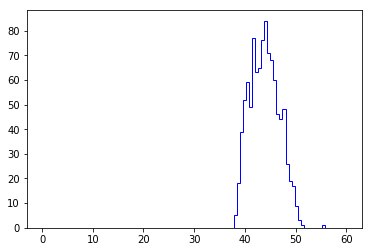

In [232]:
n,b,o=hist(chi2,bins=100,histtype='step',log=False,color='b',label='All',range=[0,60])

In [166]:
dfic = pd.read_csv("IC_scrambled2/0.csv")
np.log10(max(dfic.ICsigs)/max(dfic.ICFPRD))

3.008357783318047

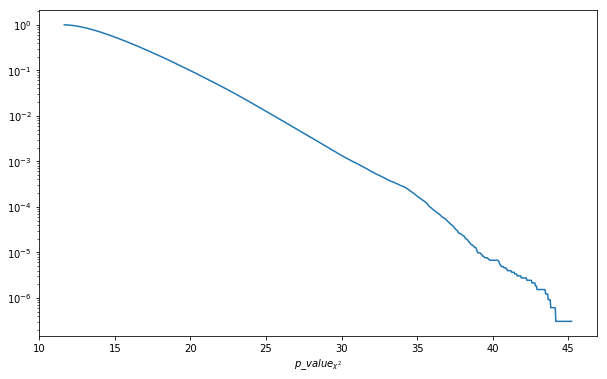

In [3]:
rcParams['figure.figsize']=10,6
cdfLLH =  np.load('CDF_Chi2.npz')
CDF = []
for item in cdfLLH.iteritems():
    CDF.append(item[1])
n = CDF[0]
b = CDF[1]
bin_centers = b[:-1] + 0.5*(b[1:] - b[:-1])
f2 = interp1d(bin_centers, np.cumsum(n*np.diff(b)))
x=linspace(bin_centers[0],bin_centers[-2],1000)
plot(x,1-f2(x))
yscale('log')
xlabel(r'$p\_value_{\chi^2}$')

In [6]:
hwcsig=6.
pvalueHWC = 1-stats.norm.cdf(hwcsig)


## Prepare Archival/Simulated Data

In [3]:
# Read HAWC data file
dfh = pd.read_csv("hawc_data_2.csv")
dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
sigma_hawc = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=len(dfh), random_state=None)#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
dfh['HsigmaR']=sigma_hawc
dfh['HTime_c']=pd.to_datetime(dfh['HTime_c'])
dfh = dfh.sort_values(by='HTime_c')
dfh.head(5)

,HDec,HRA,HsigmaR,HTime_i,HTime_c,HTime_f,Hduration,Hsig
1,-8.423330,256.377,0.081626,2016-01-01 14:03:17,2016-01-01 16:52:28,2016-01-01 19:41:39,5.63943,2.85261
27,-19.431800,258.047,0.092014,2016-01-01 14:49:10,2016-01-01 16:59:13,2016-01-01 19:09:16,4.33481,3.08562
14,-12.673900,258.487,0.092110,2016-01-01 14:24:19,2016-01-01 17:00:55,2016-01-01 19:37:31,5.22007,2.95240
7,-8.159460,258.882,0.096307,2016-01-01 14:12:34,2016-01-01 17:02:28,2016-01-01 19:52:22,5.66324,3.24719
3,-0.708832,261.123,0.073197,2016-01-01 14:04:34,2016-01-01 17:11:22,2016-01-01 20:18:10,6.22688,3.03762


In [4]:
# Read IceCube data file
dfic = pd.read_csv("ic-singlet-jan16.csv")
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')
dfic['ICFPRD'] = np.power(10,-2.5)#np.power(10,signaless(len(dfic)))
dfic.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec,ICFPRD
0,-34.7199,205.1050,0.196344,2016-01-01 00:04:57,98664,0.003162
1,54.3056,107.9430,0.534230,2016-01-01 00:05:40,122278,0.003162
2,57.3919,108.1390,1.176690,2016-01-01 00:05:48,730722,0.003162
3,-32.6259,332.9440,0.175290,2016-01-01 00:06:08,981306,0.003162
4,22.6634,20.1443,2.750110,2016-01-01 00:15:24,288569,0.003162


In [5]:
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
FOV = np.deg2rad(50.)
hwcArea = 2.*np.pi*(1-np.cos(FOV))
all_event_list=[]
for h in dfh.itertuples():
    dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
    event_list=[]
    event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,probBkgHAWC(h.HDec),1-stats.norm.cdf(h.Hsig)])
    for ic in dfw.itertuples():
        spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
        if spc<minspc:
            event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), 1/(2*np.pi), ic.ICFPRD])
    all_event_list.append(event_list)
    
#Just paired events
all_ev_nut = [x for x in all_event_list if len(x)>1]

In [6]:
len(all_ev_nut)

2493

In [7]:
# Use Scipy optimizer to find the Maximum likelihood and source position
# Case of llh with spatial terms: 
best_fit_val = []
#TempTerm=True
for ev in all_ev_nut:
    #if TempTerm:
    #solution = sc.optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
    #else:
    solution = optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')#'BFGS')
    pcluster = pNuCluster(ev)
    psigma = ev[0][5]
    
    
    stderr = 0.
    jacerr = 0.
    avgdist = 0.
    stddev = 0.
    j=0
    n=0

    if solution.success:
        res = list(solution.x)
        for part in ev:
            #print part[0],part[1],part[2],solution.x[0],solution.x[1]
            stderr += 1./(part[2]**2)
            tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
            tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
            stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
            avgdist +=tmpdist1#+ tmpdist2
            #print tmpdist1, tmpdist2
            j+=1
        #print avgdist,solution.fun
        stderr = np.sqrt(1/stderr)
        jacerr = np.sqrt(jacerr)
        avgdist /= j
        stddev /= j
        stddev = np.sqrt(stddev)
    
        res.append(stderr)
        #res.append(jacerr)
        res.append(-1*solution.fun)
        res.append(avgdist)
        res.append(stddev)
        res.append(len(ev)-1)
        res.append(pcluster)
        res.append(psigma)
        res.append(ev)
        best_fit_val.append(res)

In [12]:
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[-1]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[-1]) > 2])

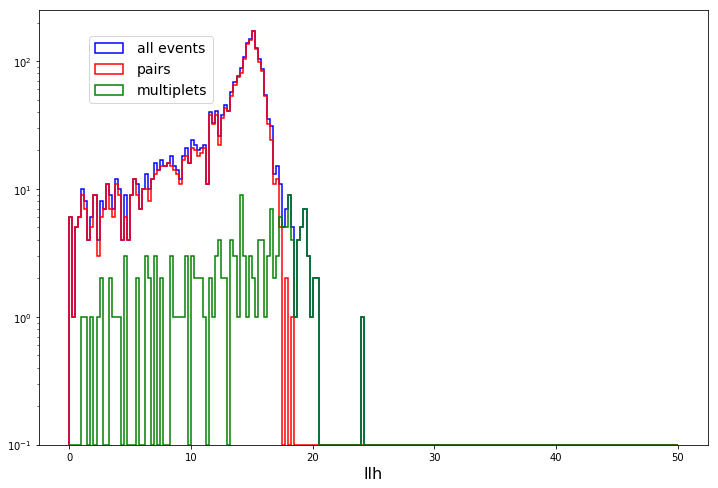

In [10]:
# Plot the histogram of llh values
rcParams['figure.figsize']=12,8
_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.26,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
#xscale('log')